In [19]:
%matplotlib inline

In [20]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
%autoreload 2

In [26]:
import pandas
import os
import numpy
from matplotlib import pyplot
import plotnine as p9

In [22]:
import matplotlib

In [23]:
matplotlib.__version__

'3.3.2'

In [24]:
from bcfit import inferFitness

In [25]:
inferFitness?

Signature:
inferFitness(
    barcodes,
    cycleTimes,
    allReads,
    outputFolder=None,
    experimentName=None,
    neutralBarcodes=None,
    multNoiseThresh=3000.0,
    zCutoff=2.7,
    multNoiseBase=0.1,
    lowCoverageThresh=500000.0,
    sparsityThresh=None,
)
Docstring:
inferFitness - main fitness inference function. Expects barcodes, cycle times, and reads; returns dictionary of
fitness inference data for all replicates. See Venkataram et. al. Cell 2016 for details of fitness assay algorithm.
All fitnesses reported per cycle.

Required parameters:

:param barcodes: N x 1 list of all barcodes
:param cycleTimes: 1 x q list of cycle times
:param allReads: dictionary of length r, where key is replicate name, and value is N x q matrix of reads

Optional parameters:
:param outputFolder: folder to save fitness data output. Saved in tab separated column formats.
:param experimentName: name of experiment, used in saving fitness files
:param neutralBarcodes: list of putatively neutral

## Load data

In [27]:
# Common part of all paths to be defined.
data_root_path = '/home/grotec/Repositories/lineage-tracking/'

In [28]:
# Location of experimental data (bartender output.)
path_to_experimental_data = os.path.join(
    data_root_path,
    'data/barcode_frequencies/LTtest/experimental_cluster.txt'
)

In [124]:
# Read in the data.
raw = pandas.read_csv(path_to_experimental_data, index_col=0)

In [125]:
raw.head()

,Center,Cluster.Score,time_point_1,time_point_2,time_point_3,time_point_4,time_point_5,time_point_6,time_point_7,time_point_8,time_point_9,time_point_10
Cluster.ID,,,,,,,,,,,,
1,ATGTGT,0.088880,12,13,12,2,2,1,8,0,8,31
2,AGGGAC,0.000000,18,8,7,0,0,0,0,0,0,1
3,TTACTT,0.036041,93,100,45,11,5,0,4,2,2,1
4,ATTCCG,0.000000,117,131,63,13,0,3,7,0,2,4
5,GCAGGC,0.802353,12,14,15,2,0,1,0,0,0,1


### Drop the cluster score

In [126]:
del raw["Cluster.Score"]

In [127]:
# Reindex
raw.rename(axis=1, mapper={"Center":"barcode"}, inplace=True)

In [128]:
raw = raw.set_index("barcode")

In [130]:
# Unique barcodes?
raw.index.is_unique

True

### Sort by total abundance

In [150]:
raw.head()

,time_point_1,time_point_2,time_point_3,time_point_4,time_point_5,time_point_6,time_point_7,time_point_8,time_point_9,time_point_10
barcode,,,,,,,,,,
ACGTTGTCC,73,51,242,421,576,748,990,4031,6936,6892
AAAAAGCCAAGGC,116,336,588,2089,3049,2415,2079,3291,2233,2494
TTTACTC,118,158,519,6284,438,2550,1295,2818,262,331
ACTATCACTATTACAAAA,86,282,1017,1583,1315,2628,1865,1079,689,707
TGGACATCGGCC,849,806,879,748,683,1325,590,855,1448,766


In [244]:
# Rename columns
raw.columns = raw.columns.str.replace("time_point_", "").astype(int)

In [245]:
raw.head()

,1,2,3,4,5,6,7,8,9,10
barcode,,,,,,,,,,
ACGTTGTCC,73,51,242,421,576,748,990,4031,6936,6892
AAAAAGCCAAGGC,116,336,588,2089,3049,2415,2079,3291,2233,2494
TTTACTC,118,158,519,6284,438,2550,1295,2818,262,331
ACTATCACTATTACAAAA,86,282,1017,1583,1315,2628,1865,1079,689,707
TGGACATCGGCC,849,806,879,748,683,1325,590,855,1448,766


In [279]:
coverage = raw.sum(axis=0)

In [280]:
coverage.name="coverage"

In [281]:
coverage

1     131497
2     133003
3      81940
4      27571
5      16722
6      17964
7      19643
8      19862
9      18655
10     19259
Name: coverage, dtype: int64

In [274]:
abundance = raw.sum(axis=1)

In [275]:
abundance.name="abundance"

In [276]:
abundance

barcode
ACGTTGTCC                    20960
AAAAAGCCAAGGC                18690
TTTACTC                      14773
ACTATCACTATTACAAAA           11251
TGGACATCGGCC                  8949
                             ...  
CTCACCTGTCGGGG                   1
AATGCCCCCGCGGG                   1
AAAGCCTCTTGCCC                   1
CGAGGAATTACGGG                   1
TAGCTCAGCTCATGCATGGTGCCCG        1
Name: abundance, Length: 7222, dtype: int64

In [277]:
raw = raw.sort_index(key=lambda m: abundance[m],ascending=False)

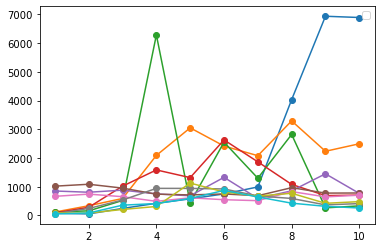

In [278]:
# Plot some lineages
raw.head(10).T.plot(style="-o");
pyplot.legend([])

### Get the list of barcodes

In [152]:
barcodes = raw.index.to_list()

In [153]:
barcodes[:10]

['ACGTTGTCC',
 'AAAAAGCCAAGGC',
 'TTTACTC',
 'ACTATCACTATTACAAAA',
 'TGGACATCGGCC',
 'TGGACAT',
 'AAAATTAAAAATGACAAAA',
 'ATCATCGGTGACGATTCC',
 'CCGGACG',
 'TTAGGGACACCTTCGCC']

### Cycle times (confirm this with Loukas)

In [246]:
cycle_times = raw.columns.to_list()

In [247]:
cycle_times

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

## Setup the all_reads dict

In [156]:
all_reads = {"rep1": raw.values}

In [157]:
all_reads['rep1'].shape

(7222, 10)

In [158]:
# Test run
fitness_data = inferFitness(barcodes=barcodes,
             cycleTimes=cycle_times,
             allReads=all_reads,
             lowCoverageThresh=1e4,
#              sparsityThresh=None,
             
             )

/home/grotec/Repositories/pybcfit/bcfit.py:224: RuntimeWarning: divide by zero encountered in power
/home/grotec/Repositories/pybcfit/bcfit.py:224: RuntimeWarning: invalid value encountered in multiply


Multiplicative noise consistency checks

rep1  inconsistent times:

No clear inconsistencies



/home/grotec/Repositories/pybcfit/bcfit.py:383: RuntimeWarning: divide by zero encountered in log
/home/grotec/Repositories/pybcfit/bcfit.py:383: RuntimeWarning: invalid value encountered in subtract
/home/grotec/Repositories/pybcfit/bcfit.py:388: RuntimeWarning: divide by zero encountered in power
/home/grotec/Repositories/pybcfit/bcfit.py:420: RuntimeWarning: invalid value encountered in multiply
/home/grotec/Repositories/pybcfit/bcfit.py:421: RuntimeWarning: divide by zero encountered in power


In [159]:
fitness_data=fitness_data['rep1']

In [160]:
fitness_data.keys()

dict_keys(['neutralBarcodes', 'barcodes', 'timePointsUsed', 'kappas', 'multNoiseParams', 'meanFitness', 'allTimeFitness', 'allTimeErrors', 'aveFitness', 'aveError', 'zScores'])

In [162]:
len(fitness_data['neutralBarcodes'])

65

As per the manual, this is quite small. Manual says, about 300 neutral lineages are needed.

#### Plot the neutral barcodes

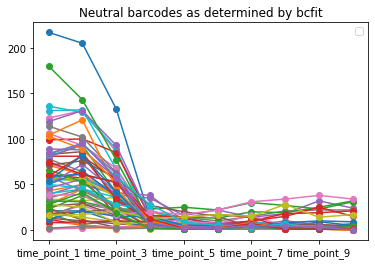

In [167]:
nbcs = fitness_data['neutralBarcodes']
raw.loc[nbcs,:].T.plot(style="-o", title="Neutral barcodes as determined by bcfit"); pyplot.legend([])

In [168]:
fitness_data['timePointsUsed']

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [169]:
fitness_data['allTimeFitness'].shape

(7222, 9)

In [170]:
fitness_per_lineage = pandas.DataFrame(index=barcodes,
                                       columns=fitness_data['timePointsUsed'][1:],
                                       data=fitness_data['allTimeFitness']
                                      )

In [177]:
errors_per_lineage = pandas.DataFrame(index=barcodes,
                                       columns=fitness_data['timePointsUsed'][1:],
                                       data=fitness_data['allTimeErrors']
                                      )

In [183]:
neutral_bcs = pandas.DataFrame(index=barcodes, columns=["neutral"], data=[bc in fitness_data["neutralBarcodes"] for bc in barcodes])

In [184]:
neutral_bcs

,neutral
ACGTTGTCC,False
AAAAAGCCAAGGC,False
TTTACTC,False
ACTATCACTATTACAAAA,False
TGGACATCGGCC,False
...,...
CTCACCTGTCGGGG,False
AATGCCCCCGCGGG,False
AAAGCCTCTTGCCC,False
CGAGGAATTACGGG,False


In [185]:
multiplicative_noise = pandas.Series(index=fitness_data['timePointsUsed'][1:], data=fitness_data['multNoiseParams'])

In [187]:
mean_fitness = pandas.Series(index=fitness_data['timePointsUsed'][1:], data=fitness_data['meanFitness'])

In [232]:
average_fitness = pandas.DataFrame(index=barcodes, columns=["avg. fitness"], data=fitness_data['aveFitness'])

In [231]:
average_error = pandas.DataFrame(index=barcodes, columns=['avg. error'], data=fitness_data['aveError'])

In [255]:
means = pandas.DataFrame.from_dict({"means":pandas.concat([
    coverage,
    mean_fitness,
    multiplicative_noise, ],
    keys=["counts", "fitness", 'error'],
    names=['parameter', 'time point'])}, orient='index')

In [256]:
means

counts                                                         \
             1         2        3        4        5        6        7    
means  131497.0  133003.0  81940.0  27571.0  16722.0  17964.0  19643.0   

                                  ...   fitness error                      \
            8        9        10  ...        10    2    3    4    5    6    
means  19862.0  18655.0  19259.0  ...  0.022842   0.1  0.1  0.1  0.1  0.1   

                           
        7    8    9    10  
means  0.1  0.1  0.1  0.1  

[1 rows x 28 columns]

In [282]:
tmp = pandas.concat([
                     raw,
                     fitness_per_lineage,
                     errors_per_lineage,
                    ],
                    axis=1,
                    keys=(
                        'counts',
                        'fitness',
                          'error',
                         ),
                    names=('parameter',
                           'time point'),
                   )

In [283]:
tmp

parameter                 counts                                           \
time point                    1    2     3     4     5     6     7     8    
barcode                                                                     
ACGTTGTCC                     73   51   242   421   576   748   990  4031   
AAAAAGCCAAGGC                116  336   588  2089  3049  2415  2079  3291   
TTTACTC                      118  158   519  6284   438  2550  1295  2818   
ACTATCACTATTACAAAA            86  282  1017  1583  1315  2628  1865  1079   
TGGACATCGGCC                 849  806   879   748   683  1325   590   855   
...                          ...  ...   ...   ...   ...   ...   ...   ...   
CTCACCTGTCGGGG                 0    0     0     0     0     0     0     0   
AATGCCCCCGCGGG                 0    0     0     0     0     0     0     0   
AAAGCCTCTTGCCC                 0    0     0     0     0     0     0     0   
CGAGGAATTACGGG                 0    0     0     0     0     0     0     0   
TAGCTCAGCTCATGCATGGTGCCCG      1    0     0     0     0     0     0     0   

parameter                              ... fitness     error            \
time point                   9     10  ...      10        2         3    
barcode                                ...                               
ACGTTGTCC                  6936  6892  ...     NaN       inf  1.147942   
AAAAAGCCAAGGC              2233  2494  ...     NaN  0.715682       inf   
TTTACTC                     262   331  ...     NaN  0.397123  0.459560   
ACTATCACTATTACAAAA          689   707  ...     NaN  0.345216  0.667775   
TGGACATCGGCC               1448   766  ...     NaN  0.315720  0.394091   
...                         ...   ...  ...     ...       ...       ...   
CTCACCTGTCGGGG                0     1  ...     NaN  0.715682       inf   
AATGCCCCCGCGGG                0     1  ...     NaN       inf  1.620353   
AAAGCCTCTTGCCC                0     1  ...     inf  0.306105  0.459560   
CGAGGAATTACGGG                0     1  ...     NaN  0.421189  0.667775   
TAGCTCAGCTCATGCATGGTGCCCG     0     0  ...     NaN  0.510980  0.619394   

parameter                                                                    \
time point                       4         5         6         7    8    9    
barcode                                                                       
ACGTTGTCC                       inf       inf       inf       inf  inf  inf   
AAAAAGCCAAGGC                   inf       inf       inf       inf  inf  inf   
TTTACTC                         inf       inf       inf  0.923358  inf  inf   
ACTATCACTATTACAAAA              inf       inf       inf  1.301991  inf  inf   
TGGACATCGGCC               3.012255       inf       inf  1.064638  inf  inf   
...                             ...       ...       ...       ...  ...  ...   
CTCACCTGTCGGGG             3.012255       inf       inf       inf  inf  inf   
AATGCCCCCGCGGG                  inf       inf       inf       inf  inf  inf   
AAAGCCTCTTGCCC             1.233131  1.152518       inf  1.301991  inf  inf   
CGAGGAATTACGGG             3.012255       inf       inf       inf  inf  inf   
TAGCTCAGCTCATGCATGGTGCCCG       inf       inf  0.571103  1.064638  inf  inf   

parameter                            
time point                       10  
barcode                              
ACGTTGTCC                       inf  
AAAAAGCCAAGGC                   inf  
TTTACTC                         inf  
ACTATCACTATTACAAAA              inf  
TGGACATCGGCC                    inf  
...                             ...  
CTCACCTGTCGGGG                  inf  
AATGCCCCCGCGGG                  inf  
AAAGCCTCTTGCCC             1.103988  
CGAGGAATTACGGG                  inf  
TAGCTCAGCTCATGCATGGTGCCCG       inf  

[7222 rows x 28 columns]

In [284]:
tmp=  pandas.concat([tmp, means])

In [285]:
tmp2 = pandas.concat([
                     abundance,
                     neutral_bcs,
                     average_fitness,
                     average_error,
                     ], axis=1, 
                    keys=["abundance", "neutral", 'avg. fitness', 'avg. error'])

In [286]:
tmp2

,abundance,neutral,avg. fitness,avg. error
,abundance,neutral,avg. fitness,avg. error
barcode,,,,
ACGTTGTCC,20960,False,NaN,1.147942
AAAAAGCCAAGGC,18690,False,NaN,0.715682
TTTACTC,14773,False,NaN,0.285729
ACTATCACTATTACAAAA,11251,False,NaN,0.298494
TGGACATCGGCC,8949,False,NaN,0.239295
...,...,...,...,...
CTCACCTGTCGGGG,1,False,NaN,0.696299
AATGCCCCCGCGGG,1,False,NaN,1.620353


In [287]:
data = pandas.concat([tmp, tmp2], axis=1)

<AxesSubplot:xlabel='time point'>

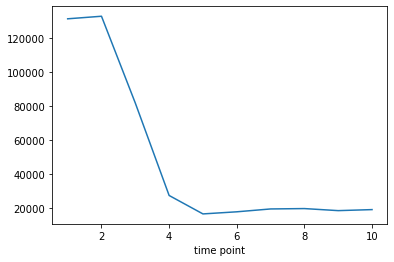

In [300]:
data.loc['means',('counts')].plot()

In [313]:
data.loc[:barcodes[-1],('error')]

time point,2,3,4,5,6,7,8,9,10
ACGTTGTCC,inf,1.147942,inf,inf,inf,inf,inf,inf,inf
AAAAAGCCAAGGC,0.715682,inf,inf,inf,inf,inf,inf,inf,inf
TTTACTC,0.397123,0.459560,inf,inf,inf,0.923358,inf,inf,inf
ACTATCACTATTACAAAA,0.345216,0.667775,inf,inf,inf,1.301991,inf,inf,inf
TGGACATCGGCC,0.315720,0.394091,3.012255,inf,inf,1.064638,inf,inf,inf
...,...,...,...,...,...,...,...,...,...
CTCACCTGTCGGGG,0.715682,inf,3.012255,inf,inf,inf,inf,inf,inf
AATGCCCCCGCGGG,inf,1.620353,inf,inf,inf,inf,inf,inf,inf
AAAGCCTCTTGCCC,0.306105,0.459560,1.233131,1.152518,inf,1.301991,inf,inf,1.103988
CGAGGAATTACGGG,0.421189,0.667775,3.012255,inf,inf,inf,inf,inf,inf


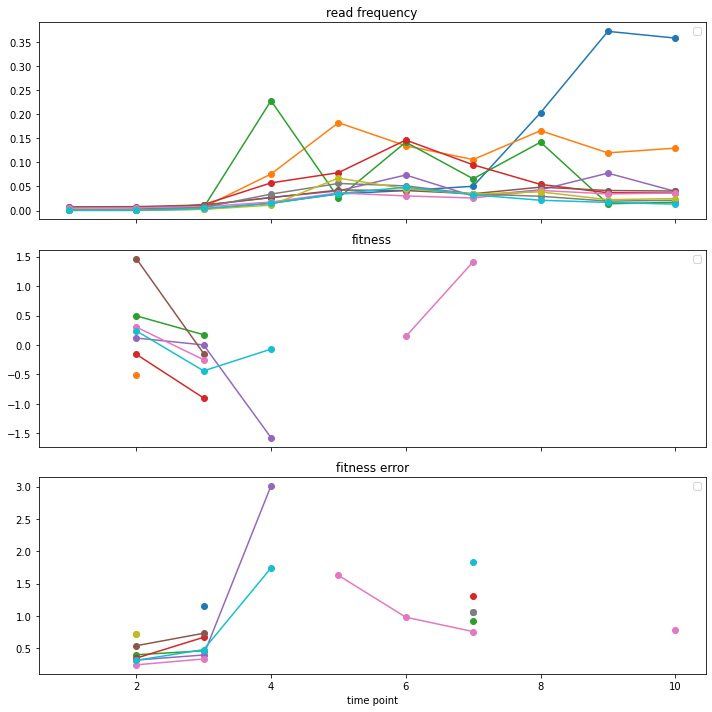

In [310]:
fig, axs = pyplot.subplots(3,1, figsize=(10,10), sharex=True)
(data.head(10).loc[:,('counts')]/data.loc['means',('counts')]).T.plot(style=style, ax=axs[0], title="read frequency") 
data.head(10).loc[:,('fitness')].T.plot(style=style, ax=axs[1], title="fitness")
data.head(10).loc[:,('error')].T.plot(style=style, ax=axs[2], title="fitness error")
for ax in axs:
    ax.legend([])
    
fig.tight_layout()

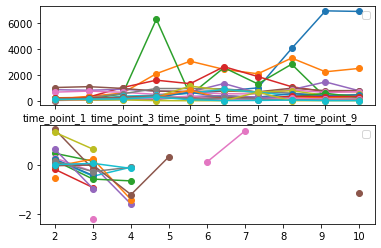

In [175]:
style="-o"
axs[0].legend([])
fitness_per_lineage.head(20).T.plot(style=style, ax=axs[1]);
axs[1].legend([])

In [176]:
fitness_data

{'neutralBarcodes': array(['AAAAATGACA', 'AACGCCACACCTAGTATGT', 'AAGAGCCT',
        'AATAACATCCAAACAG', 'AATTAC', 'AATTAG', 'ACGCAAAAATCCCCAGAT',
        'ACGCACAACAAAAT', 'ACTAAAATAAACA', 'ACTGATTTAATAAA', 'ACTGCGGAG',
        'AGCTTCCCCCGTTA', 'AGGAATTA', 'AGGTGTAG', 'ATAGACTGGT',
        'ATATATATCCTA', 'CAAACC', 'CAAGAG', 'CACAACT', 'CAGCGTTCA',
        'CATCTATGTGCCGAGAAA', 'CATGCTCACGATTACT', 'CATTGA',
        'CCCATGACCGTTGT', 'CCCCCCATCCATAGCTACT', 'CCTCAATGCAATTTA',
        'CCTCCGAAA', 'CGAGGAATTA', 'CGTAGGAGAGCTTCGTGGACAT', 'CTAACGCA',
        'CTATTCCATGAAGCTTGGC', 'CTTCTCGAGGAAT', 'CTTCTCGAGGAATTA',
        'CTTCTCGAGGAATTACC', 'GAACGTGAATC', 'GAATGTCTCTT', 'GATAATCA',
        'GATATCGCGATTC', 'GATCATCAAA', 'GCAAGA', 'GCAGGCCCTGGCTACTCAC',
        'GCCCAAGCTTCTCGAGGAATTAC', 'GGCAAA', 'GGCAAGATATTAAGGACCC',
        'GGCACATAA', 'GTATAT', 'GTCGGTGTA', 'GTCTCTT', 'GTTGTAG',
        'TAATTCCTCCAA', 'TCCCGTTATCTACTCC', 'TCGAGG', 'TCTGCT', 'TCTTGA',
        'TGAAAAGCCCTCCGTCAAT'

## Add artifical "average" lineage and use that as the reference to calculate fitness against.

In [99]:
average = pandas.DataFrame.from_dict(data={"NNNNNNN": raw.mean(axis=0).astype(int)}, orient="index")

In [100]:
average

,time_point_1,time_point_2,time_point_3,time_point_4,time_point_5,time_point_6,time_point_7,time_point_8,time_point_9,time_point_10
NNNNNNN,18,18,11,3,2,2,2,2,2,2


In [101]:
# Append
raw_with_average = average.append(raw)

In [83]:
raw_with_average.head()

,time_point_1,time_point_2,time_point_3,time_point_4,time_point_5,time_point_6,time_point_7,time_point_8,time_point_9,time_point_10
NNNNNNN,18,18,11,3,2,2,2,2,2,2
ACGTTGTCC,73,51,242,421,576,748,990,4031,6936,6892
AAAAAGCCAAGGC,116,336,588,2089,3049,2415,2079,3291,2233,2494
TTTACTC,118,158,519,6284,438,2550,1295,2818,262,331
ACTATCACTATTACAAAA,86,282,1017,1583,1315,2628,1865,1079,689,707


In [102]:
raw_with_average = raw_with_average.sort_index(key=lambda m: raw_with_average.sum(axis=1)[m],ascending=False)

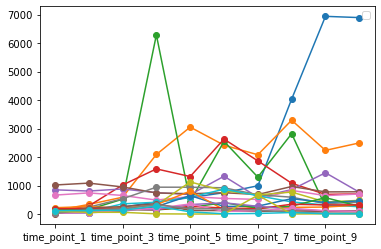

In [103]:
# Plot some lineages
raw_with_average.head(20).T.plot(style="-o");
pyplot.legend([])

### Get the list of barcodes

In [104]:
barcodes = raw_with_average.index.to_list()

In [105]:
barcodes[:10]

['ACGTTGTCC',
 'AAAAAGCCAAGGC',
 'TTTACTC',
 'ACTATCACTATTACAAAA',
 'TGGACATCGGCC',
 'TGGACAT',
 'AAAATTAAAAATGACAAAA',
 'ATCATCGGTGACGATTCC',
 'CCGGACG',
 'TTAGGGACACCTTCGCC']

### Cycle times (confirm this with Loukas)

In [108]:
cycle_times = raw_with_average.columns.str.replace("time_point_","").astype(int).to_list()

In [109]:
cycle_times

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

## Setup the all_reads dict

In [110]:
all_reads = {"rep1": raw_with_average.values}

In [111]:
all_reads['rep1'].shape

(7223, 10)

In [116]:
# Test run
fitness_data = inferFitness(barcodes=barcodes,
             cycleTimes=cycle_times,
             allReads=all_reads,
             lowCoverageThresh=0.0,
             neutralBarcodes=["NNNNNNN"],
#              sparsityThresh=None,
             
             )

Multiplicative noise consistency checks

rep1  inconsistent times:

No clear inconsistencies



/home/grotec/Repositories/pybcfit/bcfit.py:224: RuntimeWarning: divide by zero encountered in power
/home/grotec/Repositories/pybcfit/bcfit.py:224: RuntimeWarning: invalid value encountered in multiply
/home/grotec/Repositories/pybcfit/bcfit.py:221: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/envs/rq/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
/opt/anaconda3/envs/rq/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/rq/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
/home/grotec/Repositories/pybcfit/bcfit.py:220: RuntimeWarning: divide by zero encountered in log
/home/grotec/Repositories/pybcfit/bcfit.py:222: RuntimeWarning: invalid value encountered in multiply
/home/grotec/Repositories/pybcfit/bcfit.py:220: RuntimeWarning: invalid value encountered in

In [117]:
fitness_data=fitness_data['rep1']

In [118]:
fitness_data.keys()

dict_keys(['neutralBarcodes', 'barcodes', 'timePointsUsed', 'kappas', 'multNoiseParams', 'meanFitness', 'allTimeFitness', 'allTimeErrors', 'aveFitness', 'aveError', 'zScores'])

In [119]:
fitness_data['neutralBarcodes']

array([], dtype='<U25')

#### Are the most abundant lineages among the "neutral" barcodes?

In [120]:
fitness_per_lineage = pandas.DataFrame(index=barcodes, columns=cycle_times[1:], data=fitness_data['allTimeFitness'])

In [121]:
fitness_per_lineage.sort_index(key=lambda m: raw_with_average.sum(axis=1)[m],ascending=False,inplace=True)

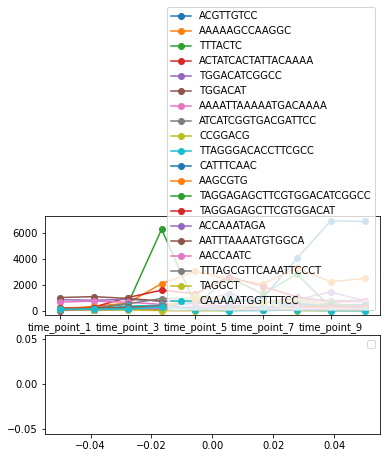

In [122]:
fig, axs = pyplot.subplots(2,1)
style="-o"
raw_with_average.head(20).T.plot(style=style, ax=axs[0])
pyplot.legend([])
fitness_per_lineage.head(20).T.plot(style=style, ax=axs[1]);
pyplot.legend([])

In [123]:
fitness_per_lineage

,2,3,4,5,6,7,8,9,10
ACGTTGTCC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAAAGCCAAGGC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTTACTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACTATCACTATTACAAAA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TGGACATCGGCC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
TAAGGATAAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CGGTAATTAA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCTCCGTTAG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCTGGATTCG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
